## Imports

In [1]:
import os
os.chdir("/project/validating_attribution_techniques/")

In [17]:
!nvidia-smi

Thu Nov  2 02:12:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 26%   49C    P2              74W / 250W |    807MiB / 11264MiB |     35%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus("0")
enable_web_access()

In [4]:
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

# from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from torchvision.models import resnet50, resnet18, vgg16, inception_v3
from torchvision.models.inception import Inception3


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


from commons.api.method.attribution import attribution


from commons.api.metric.compare_metrics import normalize, match_hist, normalize_map
from commons.api.metric.compare_metrics import SIM, CC, NSS, AUC_Judd, wasserstein_distance
from commons.api.metric.compare_metrics import calculate_metrics

In [5]:
os.chdir("/project/validating_attribution_techniques/torchCAM")
from torchcam.methods.gradient import SmoothGradCAMpp, GradCAMpp, GradCAM, LayerCAM
from torchcam.methods.activation import ScoreCAM
from torchcam.utils import overlay_mask

In [6]:
os.chdir("/project/validating_attribution_techniques/")

In [7]:
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
from io import BytesIO
from matplotlib.transforms import IdentityTransform

from PIL import Image
from numpy import random
# import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image 
import json
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

## Function

In [10]:

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

In [11]:
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.copy(image)
    patched_image[top_left_y : top_left_y+patch_size,
                  top_left_x : top_left_x+patch_size, :] = 0
    return patched_image
def generate_img_occlusion_list(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    saliency = np.array(Image.fromarray(saliency).resize(img.shape[0], img.shape[1]))
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            occlusion_saliency_statistic.append(saliency_reduce_func(saliency[top_left_y : top_left_y+patch_size,
                                                                              top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(occlusion_saliency_statistic)
def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

## Setting up

In [12]:
classes = get_imagenet_classes()

In [13]:
#Load all images
images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2_fixed.npy', allow_pickle=True)
masks = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/obj_masks_2_fixed.npy', allow_pickle=True)

In [14]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_resnet50 = resnet50(pretrained=True).to(device).eval()
model_resnet18 = resnet18(pretrained=True).to(device).eval()
# model_vgg = vgg16(pretrained=True).to(device).eval()
# model_inception3 = inception_v3(pretrained=True).to(device).eval()
# model_resnet50.eval()

/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get 

In [15]:
target_layer = model_resnet50.layer4[-1]

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Occlusion

## Ground Truth

In [15]:

img_idx = 0
patch_size = 60

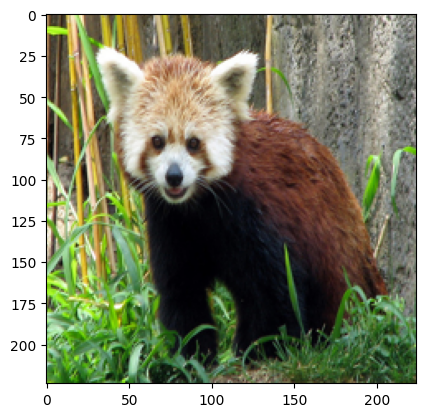

In [16]:
original_image = Image.fromarray(images[img_idx])

imshow(original_image)
input_tensor = transform(original_image).to(device)

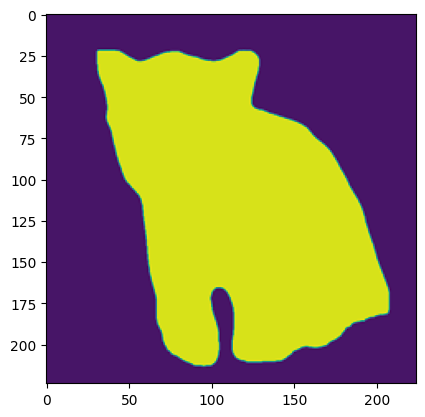

In [17]:
mask = masks[img_idx]
imshow(masks[img_idx])

In [18]:
#if in case you do not want to specify target layer(default is set to 'layer4')
grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)

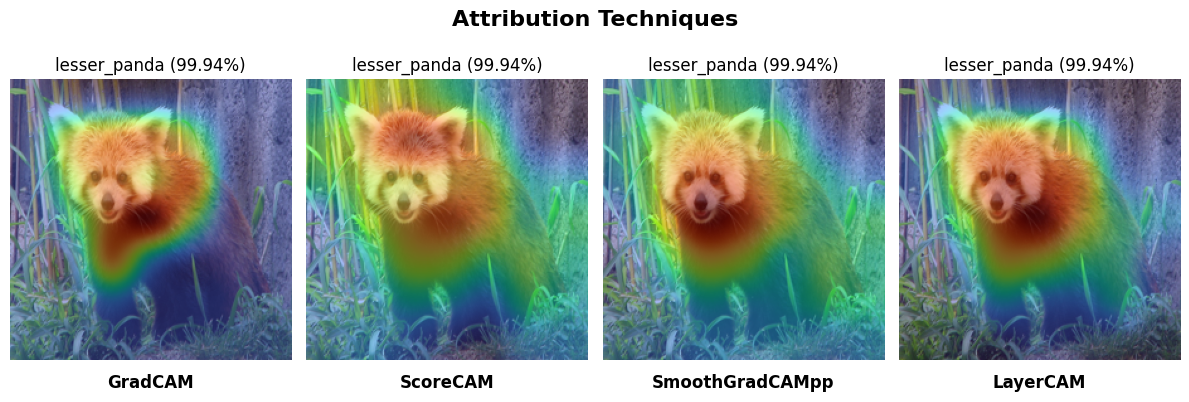

In [19]:
# fig, axes = plt.subplots(ncols=2, nrows=1)
fig, axes = plt.subplots(ncols=4, nrows=1)

fig.set_figwidth(12)
fig.set_layout_engine('tight')
fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=0.9)
# fig.set_figheight(40)
# Turn off the axis for each subplot
for ax in axes:
    ax.axis('off')
# Titles for each subplot
titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]

visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
visualize_saliency_overlay(axes[1], original_image, score_cam, score_probs, score_idx, classes);
visualize_saliency_overlay(axes[2], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
visualize_saliency_overlay(axes[3], original_image, layer_cam, layer_probs, layer_idx, classes);
for i, ax in enumerate(axes):
    ax.text(0.5, -0.1, titles[i], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/Ground_truth_{img_idx}.png")

## Generating Patches

In [20]:
gen_occlu_images = generate_img_occlusion_list_no_saliency(images[img_idx], patch_size)
np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy", gen_occlu_images)


In [21]:
sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")

In [22]:
# for i in range(len(sample_occlu_imgs)):
#     image = Image.fromarray((sample_occlu_imgs[i] * 255).astype(np.uint8))
#     # Save the image as a JPEG file
#     image.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Images_{patch_size}/Occlusion_{patch_size}_{i}.png")



### IOR Stuff

## Saliency generation for occluded images

## Method

Iteration: 0
Iteration: 1


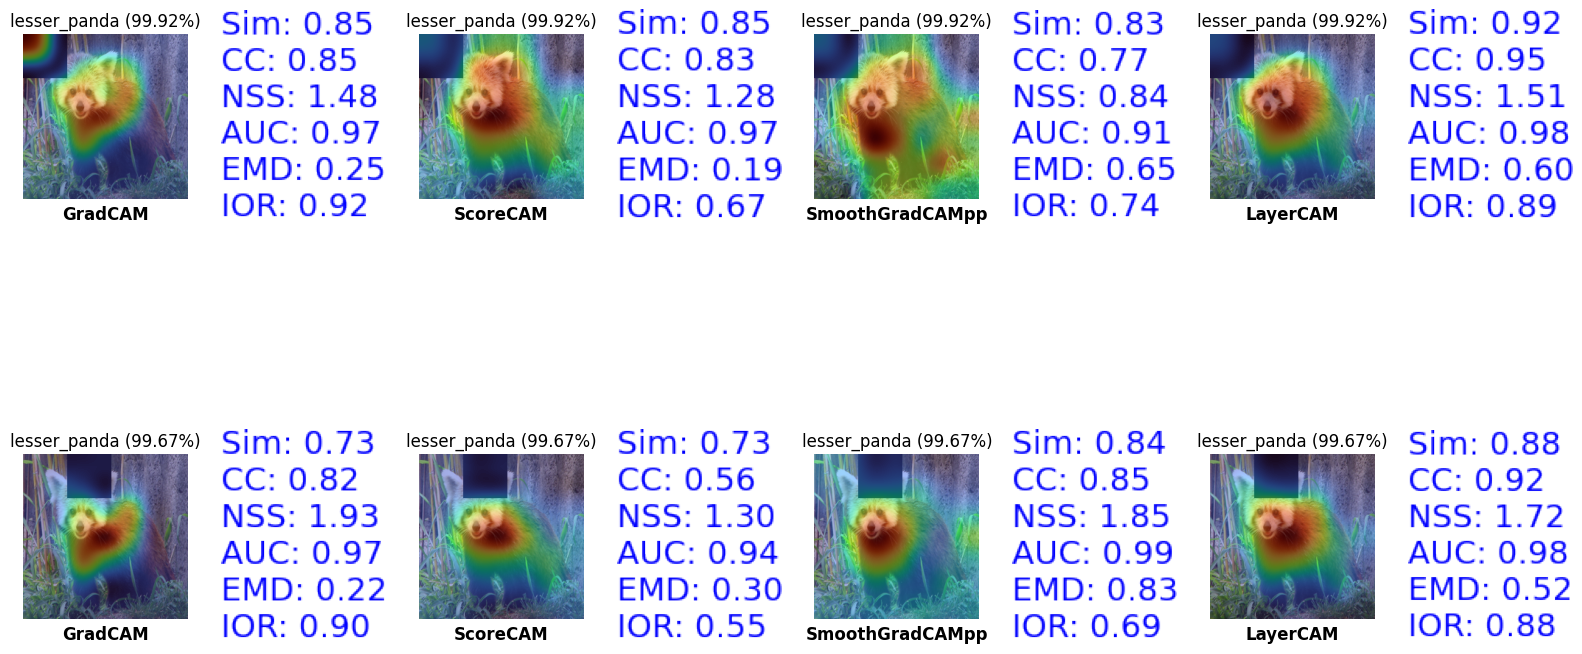

In [23]:

# img_idx = 0
gradcam = np.array([])
scorecam = np.array([])
smoothgradcampp = np.array([])
layercam = np.array([])

sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
Image.fromarray((sample_occlu_imgs[0]* 255).astype(np.uint8))

rows = len(sample_occlu_imgs)
titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
# print(rows)
fig, axes = plt.subplots(ncols=8, nrows=2)
# Iterate through axes and turn off the axes for each subplot
for row in axes:
    for ax in row:
        ax.axis('off')
# grad_cam = np.array(Image.fromarray(grad_cam).resize(mask.shape))
# score_cam = np.array(Image.fromarray(score_cam).resize(mask.shape))
# smoothgradpp_cam = np.array(Image.fromarray(smoothgradpp_cam).resize(mask.shape))
# layer_cam = np.array(Image.fromarray(layer_cam).resize(mask.shape))

for row in range(axes.shape[0]):
    for col in [0, 2, 4, 6]:
        # Add the title at the bottom of the image
        title = titles[col // 2]
        axes[row, col].text(0.5, -0.12, title, horizontalalignment='center', fontsize=12, fontweight='bold', transform=axes[row, col].transAxes)

fig.set_figheight(10)
fig.set_figwidth(20)
for row in range(axes.shape[0]):
    
    print("Iteration:", row)
    # idx = row + img_idx
    idx = row
    # img = Image.open(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Images_{patch_size}/Occlusion_{patch_size}_{row}.png")
    img = Image.fromarray((sample_occlu_imgs[row] * 255).astype(np.uint8))
    occlu_input_tensor = transform(img).to(device)

    pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet50, occlu_input_tensor, "GradCAM", target_layer)
    pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_resnet50, occlu_input_tensor, "ScoreCAM", target_layer)   
    pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_resnet50, occlu_input_tensor, "SmoothGradCAMpp", target_layer)
    pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_resnet50, occlu_input_tensor, "LayerCAM", target_layer)

    # pertubed_grad_cam = np.array(Image.fromarray(pertubed_grad_cam).resize(mask.shape))
    # pertubed_score_cam = np.array(Image.fromarray(pertubed_score_cam).resize(mask.shape))
    # pertubed_smoothgradpp_cam = np.array(Image.fromarray(pertubed_smoothgradpp_cam).resize(mask.shape))
    # pertubed_layer_cam = np.array(Image.fromarray(pertubed_layer_cam).resize(mask.shape))
    
    
    visualize_saliency_overlay(axes[row, 0], img, pertubed_grad_cam, pertubed_grad_probs, pertubed_grad_idx, classes);    
    visualize_saliency_overlay(axes[row, 2], img, pertubed_score_cam, pertubed_score_probs, pertubed_score_idx, classes);
    visualize_saliency_overlay(axes[row, 4], img, pertubed_smoothgradpp_cam, pertubed_smoothgradpp_probs, pertubed_smoothgradpp_idx, classes);    
    visualize_saliency_overlay(axes[row, 6], img, pertubed_layer_cam, pertubed_layer_probs, pertubed_layer_idx, classes);

# print(grad_cam)
# print(pertubed_grad_cam)
    
    sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
    text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"

    sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
    text_score = f"Sim: {sim_score:.2f}\nCC: {cc_score:.2f}\nNSS: {nss_score:.2f}\nAUC: {auc_score:.2f}\nEMD: {emd_score:.2f}\nIOR: {ior_score:.2f}"

    sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
    text_smooth = f"Sim: {sim_smooth:.2f}\nCC: {cc_smooth:.2f}\nNSS: {nss_smooth:.2f}\nAUC: {auc_smooth:.2f}\nEMD: {emd_smooth:.2f}\nIOR: {ior_smooth:.2f}"

    sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 
    text_layer = f"Sim: {sim_layer:.2f}\nCC: {cc_layer:.2f}\nNSS: {nss_layer:.2f}\nAUC: {auc_layer:.2f}\nEMD: {emd_layer:.2f}\nIOR: {ior_layer:.2f}"
    
#     axis.text(2*10, axis.get_ylim()[0]-2*10, f"$IOR={ior:.2f}$", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
    axes[row, 1].imshow(text_to_rgba(text_grad, color="blue", fontsize=7, dpi=200))
    axes[row, 3].imshow(text_to_rgba(text_score, color="blue", fontsize=7, dpi=200))
    axes[row, 5].imshow(text_to_rgba(text_smooth, color="blue", fontsize=7, dpi=200))
    axes[row, 7].imshow(text_to_rgba(text_layer, color="blue", fontsize=7, dpi=200))


    gradcam = np.append(gradcam, pertubed_grad_cam)
    scorecam = np.append(scorecam, pertubed_score_cam)
    smoothgradcampp = np.append(smoothgradcampp, pertubed_smoothgradpp_cam)
    layercam = np.append(layercam, pertubed_layer_cam)
    




# fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold", y=0.9)
# fig.show()
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/Occlusion_{patch_size}_{img_idx}.png")



In [24]:
np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/GradCAM_saliency_{patch_size}_idx_{img_idx}.npy", gradcam)
np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/ScoreCAM_saliency_{patch_size}_idx_{img_idx}.npy", scorecam)
np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/SmoothGradCAM_saliency_{patch_size}_idx_{img_idx}.npy", smoothgradcampp)
np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/LayerCAM_saliency_{patch_size}_idx_{img_idx}.npy", layercam)

## Loop

In [25]:
def initialize_metrics_values(techniques, metrics):
    metrics_values = {}
    for technique in techniques:
        metrics_values[technique] = {}
        for metric in metrics:
            metrics_values[technique][metric] = []
    return metrics_values

metrics_values = {
    "GradCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "ScoreCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "LayerCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "SmoothGradCAMpp": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    }
}


In [26]:
# Define the techniques and metrics you want to collect
techniques = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
metrics = ["sim", "cc", "nss", "auc", "emd", "ior"]

In [31]:
indexes = [i for i in range(41, 61)]

Image: 41 - Iteration: 0
Image: 41 - Iteration: 1
Image: 41 - Iteration: 2
Image: 41 - Iteration: 3
Image: 41 - Iteration: 4
Image: 41 - Iteration: 5
Image: 41 - Iteration: 6
Image: 41 - Iteration: 7
Image: 41 - Iteration: 8
Image: 41 - Iteration: 9
Image: 41 - Iteration: 10
Image: 41 - Iteration: 11
Image: 41 - Iteration: 12
Image: 41 - Iteration: 13
Image: 41 - Iteration: 14
Image: 41 - Iteration: 15
Image: 41 - Iteration: 16
Image: 41 - Iteration: 17
Image: 41 - Iteration: 18
Image: 41 - Iteration: 19
Image: 41 - Iteration: 20
Image: 41 - Iteration: 21
Image: 41 - Iteration: 22
Image: 41 - Iteration: 23
Image: 41 - Iteration: 24
Image: 41 - Iteration: 25
Image: 41 - Iteration: 26
Image: 41 - Iteration: 27
Image: 41 - Iteration: 28
Image: 41 - Iteration: 29
Image: 41 - Iteration: 30
Image: 41 - Iteration: 31
Image: 41 - Iteration: 32
Image: 41 - Iteration: 33
Image: 41 - Iteration: 34
Image: 41 - Iteration: 35
Image: 42 - Iteration: 0
Image: 42 - Iteration: 1
Image: 42 - Iteration: 2

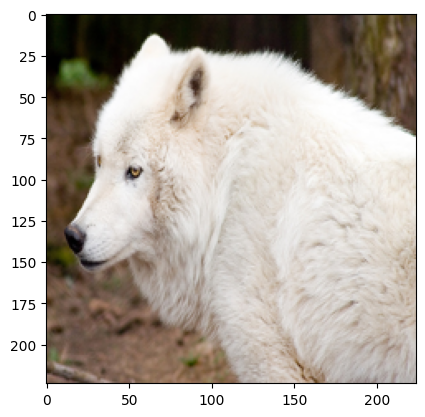

In [32]:

patch_size = 40

for img_idx in indexes:
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)
    # fig, axes = plt.subplots(ncols=2, nrows=1)
    fig, axes = plt.subplots(ncols=4, nrows=1)
    
    fig.set_figwidth(12)
    fig.set_layout_engine('tight')
    fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=0.9)
    # fig.set_figheight(40)
    # Turn off the axis for each subplot
    for ax in axes:
        ax.axis('off')
    # Titles for each subplot
    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    
    visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
    visualize_saliency_overlay(axes[1], original_image, score_cam, score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[2], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
    visualize_saliency_overlay(axes[3], original_image, layer_cam, layer_probs, layer_idx, classes);
    for i, ax in enumerate(axes):
        ax.text(0.5, -0.1, titles[i], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/Ground_truth_{img_idx}.png")
    plt.close(fig)
    gen_occlu_images = generate_img_occlusion_list_no_saliency(images[img_idx], patch_size)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy", gen_occlu_images)
    sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
    
    # img_idx = 0
    gradcam = np.array([])
    scorecam = np.array([])
    smoothgradcampp = np.array([])
    layercam = np.array([])
    
    sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
    Image.fromarray((sample_occlu_imgs[0]* 255).astype(np.uint8))
    
    rows = len(sample_occlu_imgs)
    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    # print(rows)
    fig, axes = plt.subplots(ncols=8, nrows=rows)
    # Iterate through axes and turn off the axes for each subplot
    for row in axes:
        for ax in row:
            ax.axis('off')
    
    for row in range(axes.shape[0]):
        for col in [0, 2, 4, 6]:
            # Add the title at the bottom of the image
            title = titles[col // 2]
            axes[row, col].text(0.5, -0.12, title, horizontalalignment='center', fontsize=12, fontweight='bold', transform=axes[row, col].transAxes)
    
    fig.set_figheight(125)
    fig.set_figwidth(20)
    for row in range(axes.shape[0]):
        print(f"Image: {img_idx} - Iteration: {row}")
        # idx = row + img_idx
        idx = row
        # img = Image.open(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Images_{patch_size}/Occlusion_{patch_size}_{row}.png")
        img = Image.fromarray((sample_occlu_imgs[row] * 255).astype(np.uint8))
        occlu_input_tensor = transform(img).to(device)
    
        pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet50, occlu_input_tensor, "GradCAM", target_layer)
        pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_resnet50, occlu_input_tensor, "ScoreCAM", target_layer)   
        pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_resnet50, occlu_input_tensor, "SmoothGradCAMpp", target_layer)
        pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_resnet50, occlu_input_tensor, "LayerCAM", target_layer)
        
        
        visualize_saliency_overlay(axes[row, 0], img, pertubed_grad_cam, pertubed_grad_probs, pertubed_grad_idx, classes);    
        visualize_saliency_overlay(axes[row, 2], img, pertubed_score_cam, pertubed_score_probs, pertubed_score_idx, classes);
        visualize_saliency_overlay(axes[row, 4], img, pertubed_smoothgradpp_cam, pertubed_smoothgradpp_probs, pertubed_smoothgradpp_idx, classes);    
        visualize_saliency_overlay(axes[row, 6], img, pertubed_layer_cam, pertubed_layer_probs, pertubed_layer_idx, classes);
    
    # print(grad_cam)
    # print(pertubed_grad_cam)
        
        sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
        text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"
    
        sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
        text_score = f"Sim: {sim_score:.2f}\nCC: {cc_score:.2f}\nNSS: {nss_score:.2f}\nAUC: {auc_score:.2f}\nEMD: {emd_score:.2f}\nIOR: {ior_score:.2f}"
    
        sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
        text_smooth = f"Sim: {sim_smooth:.2f}\nCC: {cc_smooth:.2f}\nNSS: {nss_smooth:.2f}\nAUC: {auc_smooth:.2f}\nEMD: {emd_smooth:.2f}\nIOR: {ior_smooth:.2f}"
    
        sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 
        text_layer = f"Sim: {sim_layer:.2f}\nCC: {cc_layer:.2f}\nNSS: {nss_layer:.2f}\nAUC: {auc_layer:.2f}\nEMD: {emd_layer:.2f}\nIOR: {ior_layer:.2f}"
        
    #     axis.text(2*10, axis.get_ylim()[0]-2*10, f"$IOR={ior:.2f}$", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
        axes[row, 1].imshow(text_to_rgba(text_grad, color="blue", fontsize=10, dpi=200))
        axes[row, 3].imshow(text_to_rgba(text_score, color="blue", fontsize=10, dpi=200))
        axes[row, 5].imshow(text_to_rgba(text_smooth, color="blue", fontsize=10, dpi=200))
        axes[row, 7].imshow(text_to_rgba(text_layer, color="blue", fontsize=10, dpi=200))

        for technique in techniques:
            for metric in metrics:
                if technique == "GradCAM":
                    calculated_value = locals()[metric.lower() + "_grad"]
                elif technique == "ScoreCAM":
                    calculated_value = locals()[metric.lower() + "_score"]
                elif technique == "SmoothGradCAMpp":
                    calculated_value = locals()[metric.lower() + "_smooth"]
                elif technique == "LayerCAM":
                    calculated_value = locals()[metric.lower() + "_layer"]
                # Append the calculated metric to the appropriate list
                metrics_values[technique][metric].append(calculated_value)

        for technique in techniques:
            for metric in metrics:
                metrics_values[technique][metric] = [float(value) for value in metrics_values[technique][metric]]
    
    
        gradcam = np.append(gradcam, pertubed_grad_cam)
        scorecam = np.append(scorecam, pertubed_score_cam)
        smoothgradcampp = np.append(smoothgradcampp, pertubed_smoothgradpp_cam)
        layercam = np.append(layercam, pertubed_layer_cam)
    
    
    
    # fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold", y=0.9)
    # fig.show()
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/Occlusion_{patch_size}_{img_idx}.png")
    plt.close(fig)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/GradCAM_saliency_{patch_size}_idx_{img_idx}.npy", gradcam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/ScoreCAM_saliency_{patch_size}_idx_{img_idx}.npy", scorecam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/SmoothGradCAM_saliency_{patch_size}_idx_{img_idx}.npy", smoothgradcampp)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/LayerCAM_saliency_{patch_size}_idx_{img_idx}.npy", layercam)

    output_file = f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/metrics_{patch_size}_{img_idx}.json"
    # Check if the file already exists and delete it
    if os.path.exists(output_file):
        os.remove(output_file)
    with open(output_file, 'w') as json_file:
        json.dump(metrics_values, json_file, indent=4)




# Summary

In [17]:
num_images = 100  # Number of images
num_patches = 9  # Number of patches per image
num_metrics = 6
cam_types = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]

indexes = [i for i in range(0, 100)]
metrics_data = {cam_type: np.zeros((num_images, num_patches, num_metrics)) for cam_type in cam_types}

In [ ]:

patch_size = 100
for img_idx in indexes:
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)

    gen_occlu_images = generate_img_occlusion_list_no_saliency(images[img_idx], patch_size)
    # np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy", gen_occlu_images)
    sample_occlu_imgs = np.array(gen_occlu_images)
    
    
    # sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
    Image.fromarray((sample_occlu_imgs[0]* 255).astype(np.uint8))
    
    rows = len(sample_occlu_imgs)
    print(rows)
    
    for row in range(rows):
        print(f"Image: {img_idx} - Iteration: {row}")
        # idx = row + img_idx
        idx = row
        # img = Image.open(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Images_{patch_size}/Occlusion_{patch_size}_{row}.png")
        img = Image.fromarray((sample_occlu_imgs[row] * 255).astype(np.uint8))
        occlu_input_tensor = transform(img).to(device)
    
        pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet50, occlu_input_tensor, "GradCAM", target_layer)
        pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_resnet50, occlu_input_tensor, "ScoreCAM", target_layer)   
        pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_resnet50, occlu_input_tensor, "SmoothGradCAMpp", target_layer)
        pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_resnet50, occlu_input_tensor, "LayerCAM", target_layer)
        
        
        sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
    
        sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
    
        sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
    
        sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 

        metrics_data["GradCAM"][img_idx, row] = [sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad]
        metrics_data["ScoreCAM"][img_idx, row] = [sim_score, cc_score, nss_score, auc_score, emd_score, ior_score]
        metrics_data["SmoothGradCAMpp"][img_idx, row] = [sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth]
        metrics_data["LayerCAM"][img_idx, row] = [sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer]


summary_metrics = {}
for cam_type in cam_types:
    cam_metrics = metrics_data[cam_type]
    summary_metrics[cam_type] = {
        "mean": np.mean(cam_metrics, axis=(0, 1)),
        "median": np.median(cam_metrics, axis=(0, 1)),
        "min": np.min(cam_metrics, axis=(0, 1)),
        "std": np.std(cam_metrics, axis=(0, 1)),
        "max": np.max(cam_metrics, axis=(0, 1))
    }

# Save metrics_data
for cam_type, data in metrics_data.items():
    np.save(f'/project/validating_attribution_techniques/shardul/data/Doc/Tables/Occlusion/ResNet50/Patch_100/{cam_type}_metrics_data.npy', data)

# Save summary_metrics
np.save(f'/project/validating_attribution_techniques/shardul/data/Doc/Tables/Occlusion/ResNet50/Patch_100/summary_metrics.npy', summary_metrics)
        




9
Image: 0 - Iteration: 0
Image: 0 - Iteration: 1
Image: 0 - Iteration: 2
Image: 0 - Iteration: 3
Image: 0 - Iteration: 4
Image: 0 - Iteration: 5
Image: 0 - Iteration: 6
Image: 0 - Iteration: 7
Image: 0 - Iteration: 8
9
Image: 1 - Iteration: 0
Image: 1 - Iteration: 1
Image: 1 - Iteration: 2
Image: 1 - Iteration: 3
Image: 1 - Iteration: 4
Image: 1 - Iteration: 5
Image: 1 - Iteration: 6
Image: 1 - Iteration: 7
Image: 1 - Iteration: 8
9
Image: 2 - Iteration: 0
Image: 2 - Iteration: 1
Image: 2 - Iteration: 2
Image: 2 - Iteration: 3
Image: 2 - Iteration: 4
Image: 2 - Iteration: 5
Image: 2 - Iteration: 6
Image: 2 - Iteration: 7
Image: 2 - Iteration: 8
9
Image: 3 - Iteration: 0
Image: 3 - Iteration: 1
Image: 3 - Iteration: 2
Image: 3 - Iteration: 3
Image: 3 - Iteration: 4
Image: 3 - Iteration: 5
Image: 3 - Iteration: 6
Image: 3 - Iteration: 7
Image: 3 - Iteration: 8
9
Image: 4 - Iteration: 0
Image: 4 - Iteration: 1
Image: 4 - Iteration: 2
Image: 4 - Iteration: 3
Image: 4 - Iteration: 4
Image:

In [11]:
# Load the saved summary_metrics
method = "GradCAM"
# sim, cc, nss, auc, emd, ior
loaded_summary_metrics = np.load('/project/validating_attribution_techniques/shardul/data/Doc/Tables/Occlusion/ResNet18/Patch_60/summary_metrics.npy', allow_pickle=True).item()

print(loaded_summary_metrics[method]["min"])
print(loaded_summary_metrics[method]["max"])
print(loaded_summary_metrics[method]["mean"])
# print(np.mean(loaded_summary_metrics["GradCAM"]["mean"]))
print(loaded_summary_metrics[method]["std"])


[ 3.80995214e-01 -3.12931132e-01 -5.04974723e-01  4.15306122e-01
  1.66806430e-02  1.00227934e-05]
[0.99660391 0.99986441 2.02228141 1.         1.84436071 0.97824715]
[0.90629332 0.90808282 1.15861694 0.96314668 0.31177372 0.49748775]
[0.08332938 0.16248919 0.34283662 0.07482891 0.22817866 0.32392369]


In [34]:
for i in loaded_summary_metrics[method]["min"]:
    print(i)

0.3809952139854431
-0.3129311322315977
-0.5049747228622437
0.4153061224489796
0.01668064296245575
1.0022793363866475e-05


In [14]:
# Load metrics_data for each CAM method
cam_types = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
standardized_metrics = {}
patch = 60

for cam_type in cam_types:
    data = np.load(f'/project/validating_attribution_techniques/shardul/data/Doc/Tables/Occlusion/ResNet18/Patch_{patch}/{cam_type}_metrics_data.npy')

    # Standardize NSS and EMD values
    nss_idx = 2  # Assuming NSS is at index 2 in your metrics data
    emd_idx = 4  # Assuming EMD is at index 4 in your metrics data

    nss_values = data[:, :, nss_idx]
    emd_values = data[:, :, emd_idx]

    # Standardize NSS to be between -1 and 1
    nss_min = -1
    nss_max = 1
    nss_values = (nss_values - np.min(nss_values)) / (np.max(nss_values) - np.min(nss_values)) * (nss_max - nss_min) + nss_min

    # Standardize EMD to be between 0 and 1
    emd_min = 0
    emd_max = 1
    emd_values = (emd_values - np.min(emd_values)) / (np.max(emd_values) - np.min(emd_values)) * (emd_max - emd_min) + emd_min

    # Non-standardized metrics
    sim_idx = 0  # Assuming Sim is at index 0 in your metrics data
    cc_idx = 1   # Assuming CC is at index 1 in your metrics data
    auc_idx = 3  # Assuming AUC is at index 3 in your metrics data
    ior_idx = 5  # Assuming IOR is at index 5 in your metrics data

    sim_values = data[:, :, sim_idx]
    cc_values = data[:, :, cc_idx]
    auc_values = data[:, :, auc_idx]
    ior_values = data[:, :, ior_idx]

    # Calculate mean, min, max, std for non-standardized values
    mean_sim = np.mean(sim_values, axis=(0, 1))
    min_sim = np.min(sim_values, axis=(0, 1))
    max_sim = np.max(sim_values, axis=(0, 1))
    std_sim = np.std(sim_values, axis=(0, 1))

    mean_cc = np.mean(cc_values, axis=(0, 1))
    min_cc = np.min(cc_values, axis=(0, 1))
    max_cc = np.max(cc_values, axis=(0, 1))
    std_cc = np.std(cc_values, axis=(0, 1))

    mean_auc = np.mean(auc_values, axis=(0, 1))
    min_auc = np.min(auc_values, axis=(0, 1))
    max_auc = np.max(auc_values, axis=(0, 1))
    std_auc = np.std(auc_values, axis=(0, 1))

    mean_ior = np.mean(ior_values, axis=(0, 1))
    min_ior = np.min(ior_values, axis=(0, 1))
    max_ior = np.max(ior_values, axis=(0, 1))
    std_ior = np.std(ior_values, axis=(0, 1))

    # Store the standardized and non-standardized metrics
    standardized_metrics[cam_type] = {
        "mean_sim": mean_sim,
        "min_sim": min_sim,
        "max_sim": max_sim,
        "std_sim": std_sim,
        "mean_cc": mean_cc,
        "min_cc": min_cc,
        "max_cc": max_cc,
        "std_cc": std_cc,
        "mean_nss": np.mean(nss_values, axis=(0, 1)),
        "min_nss": np.min(nss_values, axis=(0, 1)),
        "max_nss": np.max(nss_values, axis=(0, 1)),
        "std_nss": np.std(nss_values, axis=(0, 1)),
        "mean_auc": mean_auc,
        "min_auc": min_auc,
        "max_auc": max_auc,
        "std_auc": std_auc,
        "mean_ior": mean_ior,
        "min_ior": min_ior,
        "max_ior": max_ior,
        "std_ior": std_ior,
        "mean_emd": np.mean(emd_values, axis=(0, 1)),
        "min_emd": np.min(emd_values, axis=(0, 1)),
        "max_emd": np.max(emd_values, axis=(0, 1)),
        "std_emd": np.std(emd_values, axis=(0, 1)),
    }

# Now you have the corrected standardized NSS and EMD values between -1 and 1 and 0 and 1, respectively, along with non-standardized Sim, CC, AUC, and IOR for each CAM method
# Access them as needed, e.g., standardized_metrics["GradCAM"]["mean_nss"]


In [15]:
for cam_type, metrics in standardized_metrics.items():
    print(f"CAM Type: {cam_type}")

    # Non-standardized metrics
    print("Non-standardized metrics:")
    print(f"Min Sim: {metrics['min_sim']}")
    print(f"Max Sim: {metrics['max_sim']}")
    print(f"Mean Sim: {metrics['mean_sim']}")
    print(f"Std Sim: {metrics['std_sim']}")
    
    print(f"Min CC: {metrics['min_cc']}")
    print(f"Max CC: {metrics['max_cc']}")
    print(f"Mean CC: {metrics['mean_cc']}")
    print(f"Std CC: {metrics['std_cc']}")
    
    print("NSS:")
    print(f"Min NSS: {metrics['min_nss']}")
    print(f"Max NSS: {metrics['max_nss']}")
    print(f"Mean NSS: {metrics['mean_nss']}")
    print(f"Std NSS: {metrics['std_nss']}")
    
    print(f"Min AUC: {metrics['min_auc']}")
    print(f"Max AUC: {metrics['max_auc']}")
    print(f"Mean AUC: {metrics['mean_auc']}")
    print(f"Std AUC: {metrics['std_auc']}")
    
    print("EMD:")
    print(f"Min EMD: {metrics['min_emd']}")
    print(f"Max EMD: {metrics['max_emd']}")
    print(f"Mean EMD: {metrics['mean_emd']}")
    print(f"Std EMD: {metrics['std_emd']}")
    
    print(f"Min IOR: {metrics['min_ior']}")
    print(f"Max IOR: {metrics['max_ior']}")
    print(f"Mean IOR: {metrics['mean_ior']}")
    print(f"Std IOR: {metrics['std_ior']}")
    
    print()  # Add a blank line to separate CAM methods


CAM Type: GradCAM
Non-standardized metrics:
Min Sim: 0.3809952139854431
Max Sim: 0.9966039061546326
Mean Sim: 0.906293323095888
Std Sim: 0.08332937815212388
Min CC: -0.3129311322315977
Max CC: 0.9998644075420705
Mean CC: 0.9080828178504694
Std CC: 0.1624891885098866
NSS:
Min NSS: -1.0
Max NSS: 1.0
Mean NSS: 0.316520037070709
Std NSS: 0.2713113343391789
Min AUC: 0.4153061224489796
Max AUC: 1.0
Mean AUC: 0.9631466821091849
Std AUC: 0.07482890930960918
EMD:
Min EMD: 0.0
Max EMD: 1.0
Mean EMD: 0.16145773029386057
Std EMD: 0.12484606167001365
Min IOR: 1.0022793363866475e-05
Max IOR: 0.9782471481741296
Mean IOR: 0.4974877500861979
Std IOR: 0.3239236864575921

CAM Type: ScoreCAM
Non-standardized metrics:
Min Sim: 0.4882090091705322
Max Sim: 0.9909974932670593
Mean Sim: 0.9006005731597543
Std Sim: 0.0721408075660397
Min CC: -0.17377343550747668
Max CC: 0.9997392696225906
Mean CC: 0.8972539220689134
Std CC: 0.14849943006243302
NSS:
Min NSS: -1.0
Max NSS: 1.0
Mean NSS: 0.1597587774388477
Std NSS

In [42]:
# Load metrics_data for each CAM method and patch
cam_types = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
patches = [ 40, 60, 80, 100]

# Initialize dictionaries to accumulate the values
accumulated_metrics = {cam_type: {} for cam_type in cam_types}

for patch in patches:
    for cam_type in cam_types:
        data = np.load(f'/project/validating_attribution_techniques/shardul/data/Doc/Tables/Occlusion/InceptionV3/Patch_{patch}/{cam_type}_metrics_data.npy')

        # Standardize NSS and EMD values
        nss_idx = 2  # Assuming NSS is at index 2 in your metrics data
        emd_idx = 4  # Assuming EMD is at index 4 in your metrics data

        nss_values = data[:, :, nss_idx]
        emd_values = data[:, :, emd_idx]

        # Standardize NSS to be between -1 and 1
        nss_min = -1
        nss_max = 1
        nss_values = (nss_values - np.min(nss_values)) / (np.max(nss_values) - np.min(nss_values)) * (nss_max - nss_min) + nss_min

        # Standardize EMD to be between 0 and 1
        emd_min = 0
        emd_max = 1
        emd_values = (emd_values - np.min(emd_values)) / (np.max(emd_values) - np.min(emd_values)) * (emd_max - emd_min) + emd_min

        # Non-standardized metrics
        sim_idx = 0  # Assuming Sim is at index 0 in your metrics data
        cc_idx = 1   # Assuming CC is at index 1 in your metrics data
        auc_idx = 3  # Assuming AUC is at index 3 in your metrics data
        ior_idx = 5  # Assuming IOR is at index 5 in your metrics data

        sim_values = data[:, :, sim_idx]
        cc_values = data[:, :, cc_idx]
        auc_values = data[:, :, auc_idx]
        ior_values = data[:, :, ior_idx]

        # Calculate mean, min, max, std for non-standardized values
        mean_sim = np.mean(sim_values, axis=(0, 1))
        min_sim = np.min(sim_values, axis=(0, 1))
        max_sim = np.max(sim_values, axis=(0, 1))
        std_sim = np.std(sim_values, axis=(0, 1))

        mean_cc = np.mean(cc_values, axis=(0, 1))
        min_cc = np.min(cc_values, axis=(0, 1))
        max_cc = np.max(cc_values, axis=(0, 1))
        std_cc = np.std(cc_values, axis=(0, 1))

        mean_auc = np.mean(auc_values, axis=(0, 1))
        min_auc = np.min(auc_values, axis=(0, 1))
        max_auc = np.max(auc_values, axis=(0, 1))
        std_auc = np.std(auc_values, axis=(0, 1))

        mean_ior = np.mean(ior_values, axis=(0, 1))
        min_ior = np.min(ior_values, axis=(0, 1))
        max_ior = np.max(ior_values, axis=(0, 1))
        std_ior = np.std(ior_values, axis=(0, 1))

        # Accumulate the standardized and non-standardized metrics
        # Accumulate the standardized and non-standardized metrics
        if 'mean_sim' in accumulated_metrics[cam_type]:
            accumulated_metrics[cam_type]['mean_sim'] += mean_sim
            accumulated_metrics[cam_type]['min_sim'] += min_sim
            accumulated_metrics[cam_type]['max_sim'] += max_sim
            accumulated_metrics[cam_type]['std_sim'] += std_sim
        else:
            accumulated_metrics[cam_type]['mean_sim'] = mean_sim
            accumulated_metrics[cam_type]['min_sim'] = min_sim
            accumulated_metrics[cam_type]['max_sim'] = max_sim
            accumulated_metrics[cam_type]['std_sim'] = std_sim
        
        if 'mean_cc' in accumulated_metrics[cam_type]:
            accumulated_metrics[cam_type]['mean_cc'] += mean_cc
            accumulated_metrics[cam_type]['min_cc'] += min_cc
            accumulated_metrics[cam_type]['max_cc'] += max_cc
            accumulated_metrics[cam_type]['std_cc'] += std_cc
        else:
            accumulated_metrics[cam_type]['mean_cc'] = mean_cc
            accumulated_metrics[cam_type]['min_cc'] = min_cc
            accumulated_metrics[cam_type]['max_cc'] = max_cc
            accumulated_metrics[cam_type]['std_cc'] = std_cc
        
        if 'mean_nss' in accumulated_metrics[cam_type]:
            accumulated_metrics[cam_type]['mean_nss'] += np.mean(nss_values, axis=(0, 1))
            accumulated_metrics[cam_type]['min_nss'] += np.min(nss_values, axis=(0, 1))
            accumulated_metrics[cam_type]['max_nss'] += np.max(nss_values, axis=(0, 1))
            accumulated_metrics[cam_type]['std_nss'] += np.std(nss_values, axis=(0, 1))
        else:
            accumulated_metrics[cam_type]['mean_nss'] = np.mean(nss_values, axis=(0, 1))
            accumulated_metrics[cam_type]['min_nss'] = np.min(nss_values, axis=(0, 1))
            accumulated_metrics[cam_type]['max_nss'] = np.max(nss_values, axis=(0, 1))
            accumulated_metrics[cam_type]['std_nss'] = np.std(nss_values, axis=(0, 1))
        
        if 'mean_auc' in accumulated_metrics[cam_type]:
            accumulated_metrics[cam_type]['mean_auc'] += mean_auc
            accumulated_metrics[cam_type]['min_auc'] += min_auc
            accumulated_metrics[cam_type]['max_auc'] += max_auc
            accumulated_metrics[cam_type]['std_auc'] += std_auc
        else:
            accumulated_metrics[cam_type]['mean_auc'] = mean_auc
            accumulated_metrics[cam_type]['min_auc'] = min_auc
            accumulated_metrics[cam_type]['max_auc'] = max_auc
            accumulated_metrics[cam_type]['std_auc'] = std_auc
        
        if 'mean_ior' in accumulated_metrics[cam_type]:
            accumulated_metrics[cam_type]['mean_ior'] += mean_ior
            accumulated_metrics[cam_type]['min_ior'] += min_ior
            accumulated_metrics[cam_type]['max_ior'] += max_ior
            accumulated_metrics[cam_type]['std_ior'] += std_ior
        else:
            accumulated_metrics[cam_type]['mean_ior'] = mean_ior
            accumulated_metrics[cam_type]['min_ior'] = min_ior
            accumulated_metrics[cam_type]['max_ior'] = max_ior
            accumulated_metrics[cam_type]['std_ior'] = std_ior
        
        
        if 'mean_emd' in accumulated_metrics[cam_type]:
            accumulated_metrics[cam_type]['mean_emd'] += np.mean(emd_values, axis=(0, 1))
            accumulated_metrics[cam_type]['min_emd'] += np.min(emd_values, axis=(0, 1))
            accumulated_metrics[cam_type]['max_emd'] += np.max(emd_values, axis=(0, 1))
            accumulated_metrics[cam_type]['std_emd'] += np.std(emd_values, axis=(0, 1))
        else:
            accumulated_metrics[cam_type]['mean_emd'] = np.mean(emd_values, axis=(0, 1))
            accumulated_metrics[cam_type]['min_emd'] = np.min(emd_values, axis=(0, 1))
            accumulated_metrics[cam_type]['max_emd'] = np.max(emd_values, axis=(0, 1))
            accumulated_metrics[cam_type]['std_emd'] = np.std(emd_values, axis=(0, 1))


# Calculate the mean values for accumulated metrics
# Calculate the mean values for accumulated metrics
for cam_type in cam_types:
    for metric in ["mean_sim", "min_sim", "max_sim", "std_sim",
                   "mean_cc", "min_cc", "max_cc", "std_cc",
                   "mean_nss", "min_nss", "max_nss", "std_nss",
                   "mean_auc", "min_auc", "max_auc", "std_auc",
                   "mean_ior", "min_ior", "max_ior", "std_ior",
                   "mean_emd", "min_emd", "max_emd", "std_emd"]:
        accumulated_metrics[cam_type][metric] /= len(patches)
# Standardize EMD values to ensure they do not exceed 1
# for cam_type in cam_types:
#     accumulated_metrics[cam_type]['mean_emd'] = (accumulated_metrics[cam_type]['mean_emd'] - np.min(accumulated_metrics[cam_type]['mean_emd'])) / (np.max(accumulated_metrics[cam_type]['mean_emd']) - np.min(accumulated_metrics[cam_type]['mean_emd']))
#     accumulated_metrics[cam_type]['min_emd'] = (accumulated_metrics[cam_type]['min_emd'] - np.min(accumulated_metrics[cam_type]['min_emd'])) / (np.max(accumulated_metrics[cam_type]['min_emd']) - np.min(accumulated_metrics[cam_type]['min_emd']))
#     accumulated_metrics[cam_type]['max_emd'] = (accumulated_metrics[cam_type]['max_emd'] - np.min(accumulated_metrics[cam_type]['max_emd'])) / (np.max(accumulated_metrics[cam_type]['max_emd']) - np.min(accumulated_metrics[cam_type]['max_emd']))
#     accumulated_metrics[cam_type]['std_emd'] = (accumulated_metrics[cam_type]['std_emd'] - np.min(accumulated_metrics[cam_type]['std_emd'])) / (np.max(accumulated_metrics[cam_type]['std_emd']) - np.min(accumulated_metrics[cam_type]['std_emd']))


# Now you have the mean values of metrics across different patches for each CAM method, taking into account the standardization of NSS and EMD
# Access them as needed, e.g., accumulated_metrics["GradCAM"]["mean_sim"]


In [44]:
# List of CAM methods and metrics
cam_methods = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
metrics = ["sim", "cc", "nss", "auc", "emd", "ior"]  # Include "emd" here

# Iterate through each CAM method and metric
for cam_method in cam_methods:
    print(f"CAM Method: {cam_method}")
    for metric in metrics:
        mean_metric = accumulated_metrics[cam_method][f"mean_{metric}"]
        min_metric = accumulated_metrics[cam_method][f"min_{metric}"]
        max_metric = accumulated_metrics[cam_method][f"max_{metric}"]
        std_metric = accumulated_metrics[cam_method][f"std_{metric}"]

        print(f"{metric.upper()}:")
        print(f"Mean: {mean_metric:.4f}")
        print(f"Min: {min_metric:.4f}")
        print(f"Max: {max_metric:.4f}")
        print(f"Std: {std_metric:.4f}")

    print()  # Add an empty line between CAM methods


CAM Method: GradCAM
SIM:
Mean: 0.9104
Min: 0.3107
Max: 0.9980
Std: 0.0856
CC:
Mean: 0.9131
Min: -0.4609
Max: 0.9999
Std: 0.1596
NSS:
Mean: 0.2652
Min: -1.0000
Max: 1.0000
Std: 0.1901
AUC:
Mean: 0.9656
Min: 0.2665
Max: 1.0000
Std: 0.0737
EMD:
Mean: 0.1779
Min: 0.0000
Max: 1.0000
Std: 0.1311
IOR:
Mean: 0.4258
Min: 0.0000
Max: 0.9805
Std: 0.3017

CAM Method: ScoreCAM
SIM:
Mean: 0.8706
Min: 0.1984
Max: 0.9974
Std: 0.1173
CC:
Mean: 0.8517
Min: -0.5551
Max: 0.9999
Std: 0.2273
NSS:
Mean: 0.1029
Min: -1.0000
Max: 1.0000
Std: 0.2096
AUC:
Mean: 0.9411
Min: 0.2346
Max: 1.0000
Std: 0.1048
EMD:
Mean: 0.1493
Min: 0.0000
Max: 1.0000
Std: 0.1154
IOR:
Mean: 0.4237
Min: -0.0002
Max: 0.9753
Std: 0.3069

CAM Method: SmoothGradCAMpp
SIM:
Mean: 0.8997
Min: 0.4895
Max: 0.9815
Std: 0.0605
CC:
Mean: 0.9099
Min: -0.1792
Max: 0.9980
Std: 0.1199
NSS:
Mean: 0.2977
Min: -1.0000
Max: 1.0000
Std: 0.2008
AUC:
Mean: 0.9641
Min: 0.3266
Max: 1.0000
Std: 0.0589
EMD:
Mean: 0.2248
Min: 0.0000
Max: 1.0000
Std: 0.1326
IOR:
Me